#Time Series Analysis

##Goal: Find outliers, trends and [eropdicity in the MTA turnstile data

In [17]:
import pylab as pl
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##Data: 
MTA subway fares. It is a complete dataset of rides logged by card swipes for 600 Manhattan stations.
The data was organized by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy.
It contains 23 different subway card types (e.g. monthly pass, daily pass, Act for Disability pass…) as follows:

In [3]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [4]:
#after reading the datacube you should see:
mta = np.load("MTA_Fare.npy")
mta = mta.astype(float)
mta.shape

(600, 23, 194)

In [5]:
# clean up the data
mta[mta==-1] = np.nan

In [6]:
# Sum up fare for all ride types
mta_allsum =np.nansum(mta, axis=0)
mta_allsum = pd.DataFrame(mta_allsum)
mta_allsum.shape

(23, 194)

In [7]:
#after I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

In [8]:
date = pd.date_range(start='06/1/2010', end='02/22/2014', freq='W')

In [9]:
date = pd.date_range(start='05/21/2010', end='02/21/2014', freq='W')
date = date[2:]
date.shape

(194,)

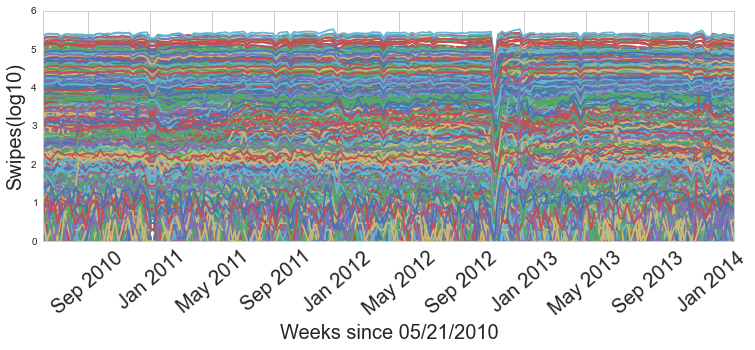

In [10]:
fig = figure(figsize=(12,4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xlabel('Weeks since 05/21/2010', size=20)
ax.set_ylabel('Swipes(log10)', size=20)
ax.tick_params(axis='x',labelsize=10)
pl.xticks(rotation=40, fontsize=20)
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        ax.plot(date, np.log10(mta[i,j]))

##Task 1:
Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Identify it and figure out what it is due to.

In [11]:
# test the approach of threshold
thresholds = [mta_allsum.loc[0,:].mean() + 3*mta_allsum.loc[0,:].std(), 
              mta_allsum.loc[0,:].mean() - 3*mta_allsum.loc[0,:].std()]
print thresholds

[16889312.352366973, 9595433.585777357]


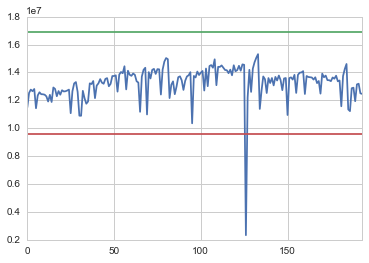

In [12]:
ax = mta_allsum.loc[0,:].plot()
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])

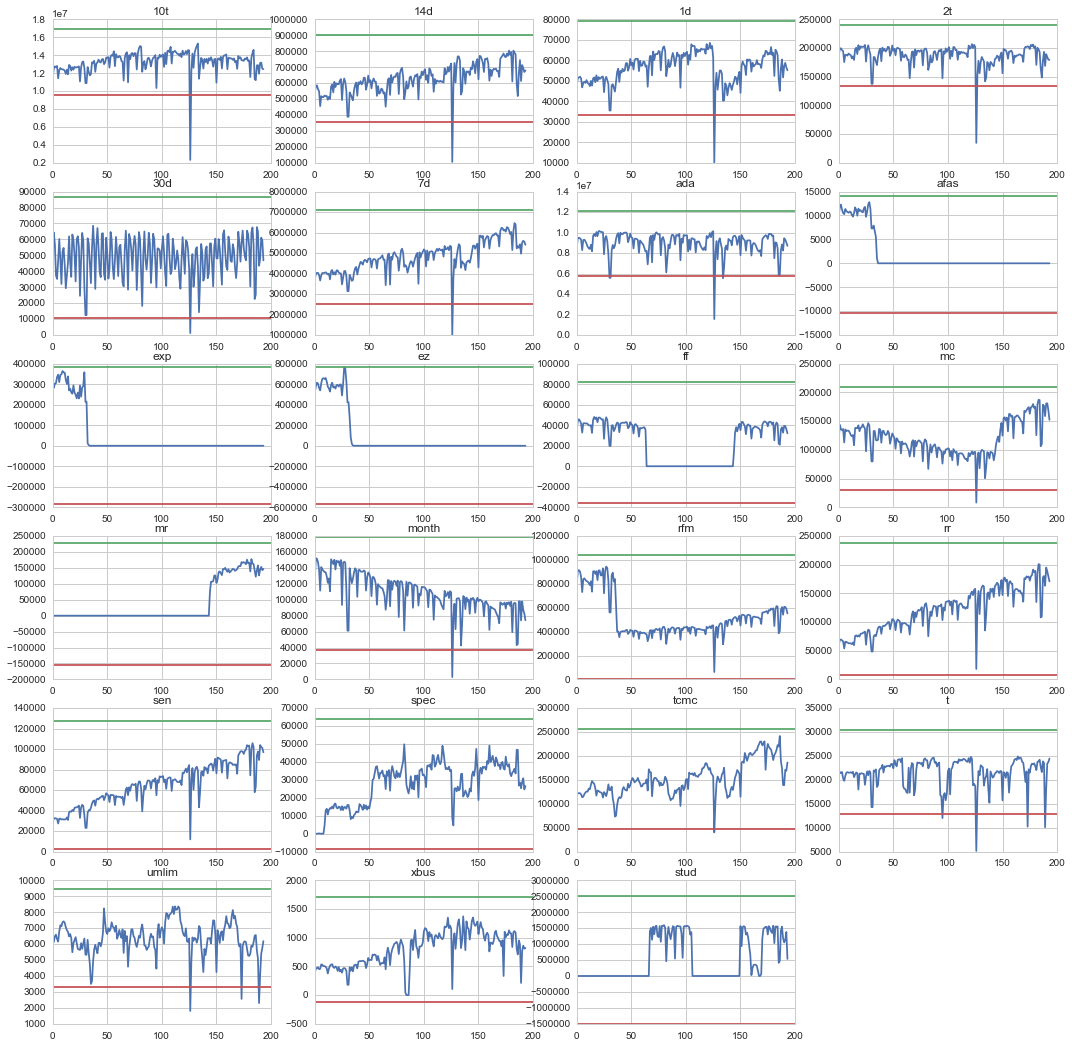

In [13]:
# Plot the week against total ride for all subway card types.
fig = plt.figure(figsize=(18,18))
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            ax.plot(mta_allsum.loc[i*4+j,:])
            thresholds = [mta_allsum.loc[i*4+j,:].mean() + 3*mta_allsum.loc[i*4+j,:].std(), 
                          mta_allsum.loc[i*4+j,:].mean() - 3*mta_allsum.loc[i*4+j,:].std()]
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])
            ax.set_title(ridetype[i*4+j])

In [14]:
# Event detection
events = pd.Series()
for i in range(23):
    thresholds = [mta_allsum.loc[i,:].mean() + 3*mta_allsum.loc[i,:].std(), 
                  mta_allsum.loc[i,:].mean() - 3*mta_allsum.loc[i,:].std()]
    event = (mta_allsum.loc[i,:]<thresholds[1])
    events = pd.concat([events, pd.Series(date[event.index[event==True]])], axis=0, ignore_index=True)

/Users/fanyining/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

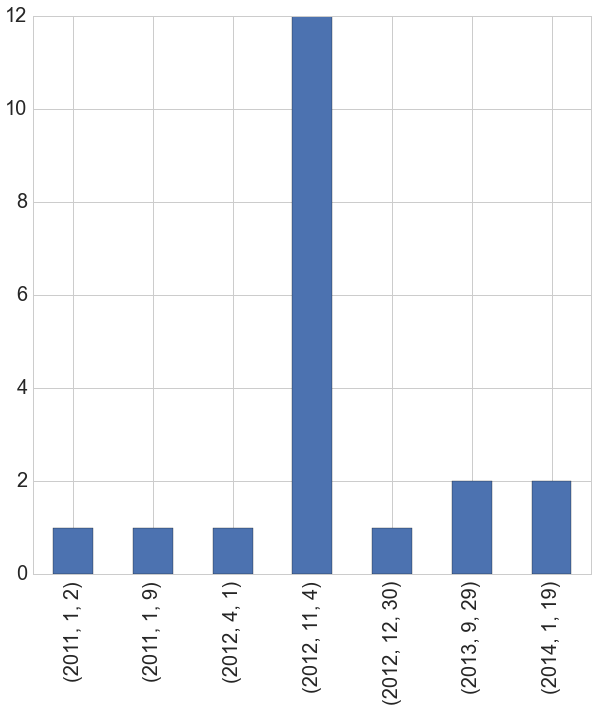

In [15]:
events.sort()
events.groupby([events.dt.year, events.dt.month, events.dt.day]).count().plot(kind="bar",fontsize=20, figsize=(10,10))
pl.xticks(rotation=90)

##Comment:
There is a significant drop in MTA fare around November 4, 2012. The reason should be the Hurricane Sandy which launched New York a week before this drop.

##Task 2:
Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

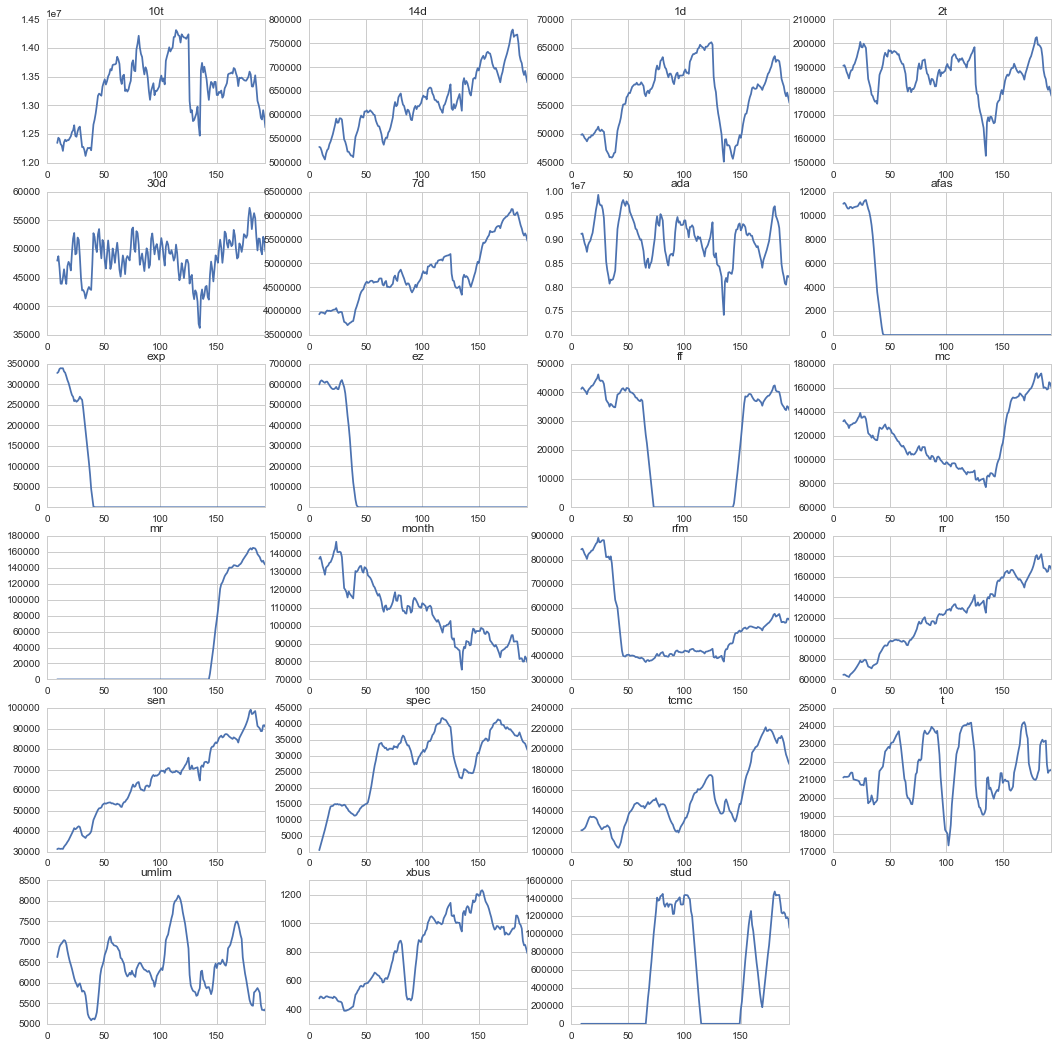

In [19]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,18))
ratio = np.zeros(23)
std = np.zeros(23)
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            roll_mean = pd.rolling_mean(mta_allsum.loc[i*4+j,:], 10)
            ax = roll_mean.plot()
            ratio[i*4+j] = roll_mean.loc[9]/roll_mean.loc[193]
            std[i*4+j] = np.nanstd(roll_mean)
            ax.set_title(ridetype[i*4+j])

In [22]:
table = pd.DataFrame({'Type' : ridetype,
                     'Ratio' : ratio,
                     'Std' : std})
print table

            Ratio            Std   Type
0        0.978667  546777.616992    10t
1        0.798681   64593.901400    14d
2        0.899810    5767.412494     1d
3        1.070889    8828.003856     2t
4        0.967317    3624.088526    30d
5        0.719555  631955.017784     7d
6        1.111307  473487.373171    ada
7     4774.478261    3794.926774   afas
8    93571.342857  101444.891854    exp
9   665798.555556  206370.776156     ez
10       1.221296   18800.946529     ff
11       0.824035   25371.323554     mc
12       0.000040   61154.073440     mr
13       1.727944   17282.833852  month
14       1.539389  153165.983867    rfm
15       0.385660   33309.135355     rr
16       0.343714   18139.761860    sen
17       0.014249   10350.797573   spec
18       0.652626   30841.454292   tcmc
19       0.978867    1570.540615      t
20       1.235996     681.416737  umlim
21       0.601566     252.041044   xbus
22       0.000000  587158.972180   stud


##Comment:
"14d", "7d", "ff" and "sen" have steadily increased.
"month", "afas", "exp", "ez" have steadily decreased.

##Task 3:

Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

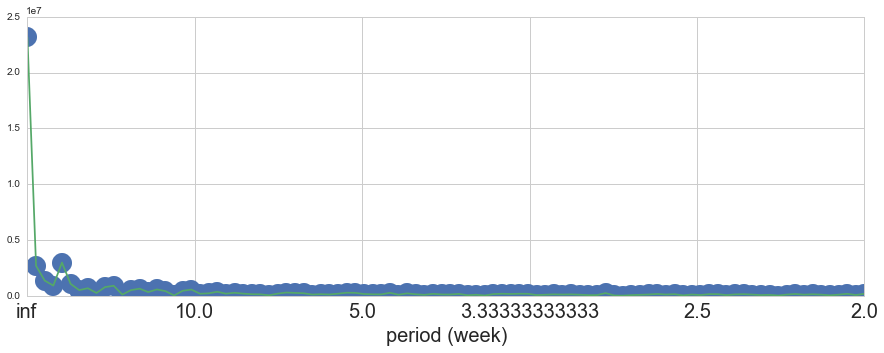

In [23]:
mta_allsum =pd.DataFrame(np.nansum(mta, axis=1))
f = np.abs(np.fft.rfft(mta_allsum.loc[0,:]))
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
sample_rate = 1
ax.plot(np.fft.rfftfreq(194, 1.0), (f), 'o', ms=20)
ax.plot(np.fft.rfftfreq(194, 1.0), (f), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)

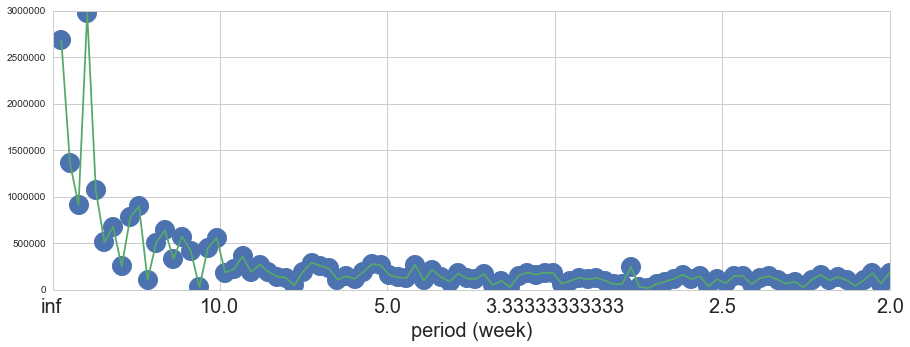

In [24]:
f = np.abs(np.fft.rfft(mta_allsum.loc[0,:]))
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
sample_rate = 1
ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=20)
ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)

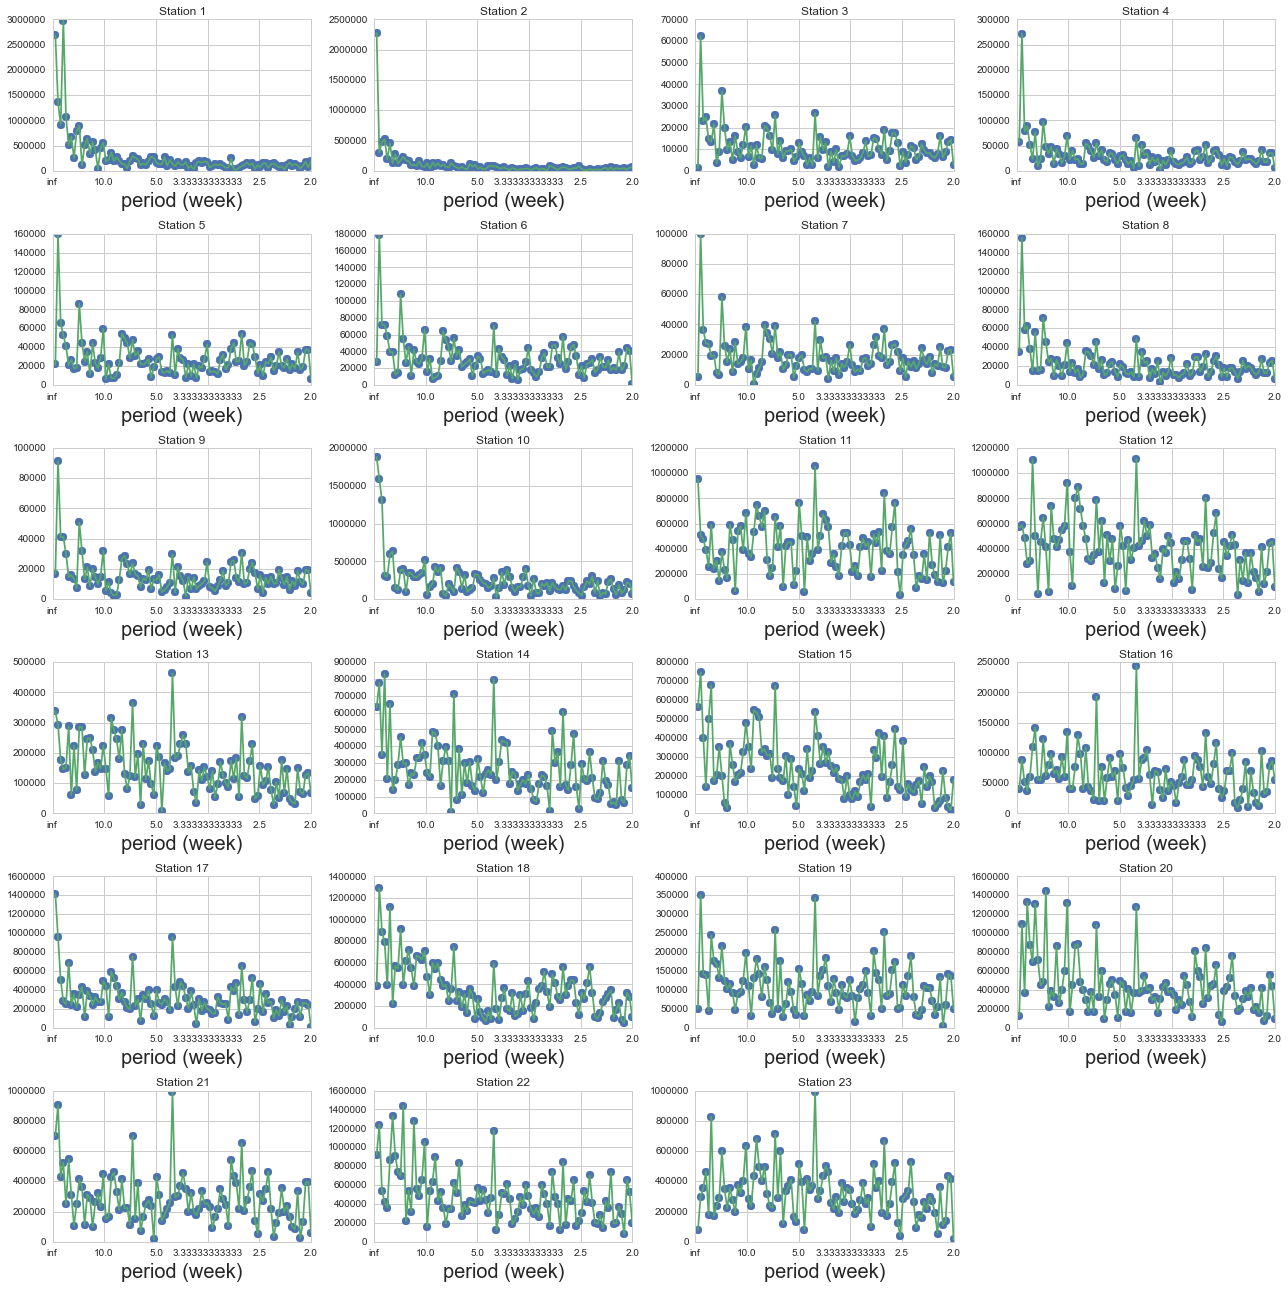

In [25]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,18))
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            f = np.abs(np.fft.rfft(mta_allsum.loc[i*4+j,:]))
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=8)
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
            ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10)
            pl.xlabel("period (week)", fontsize=20)
            ax.set_title("Station %d"%(i*4+j+1))
fig.tight_layout()

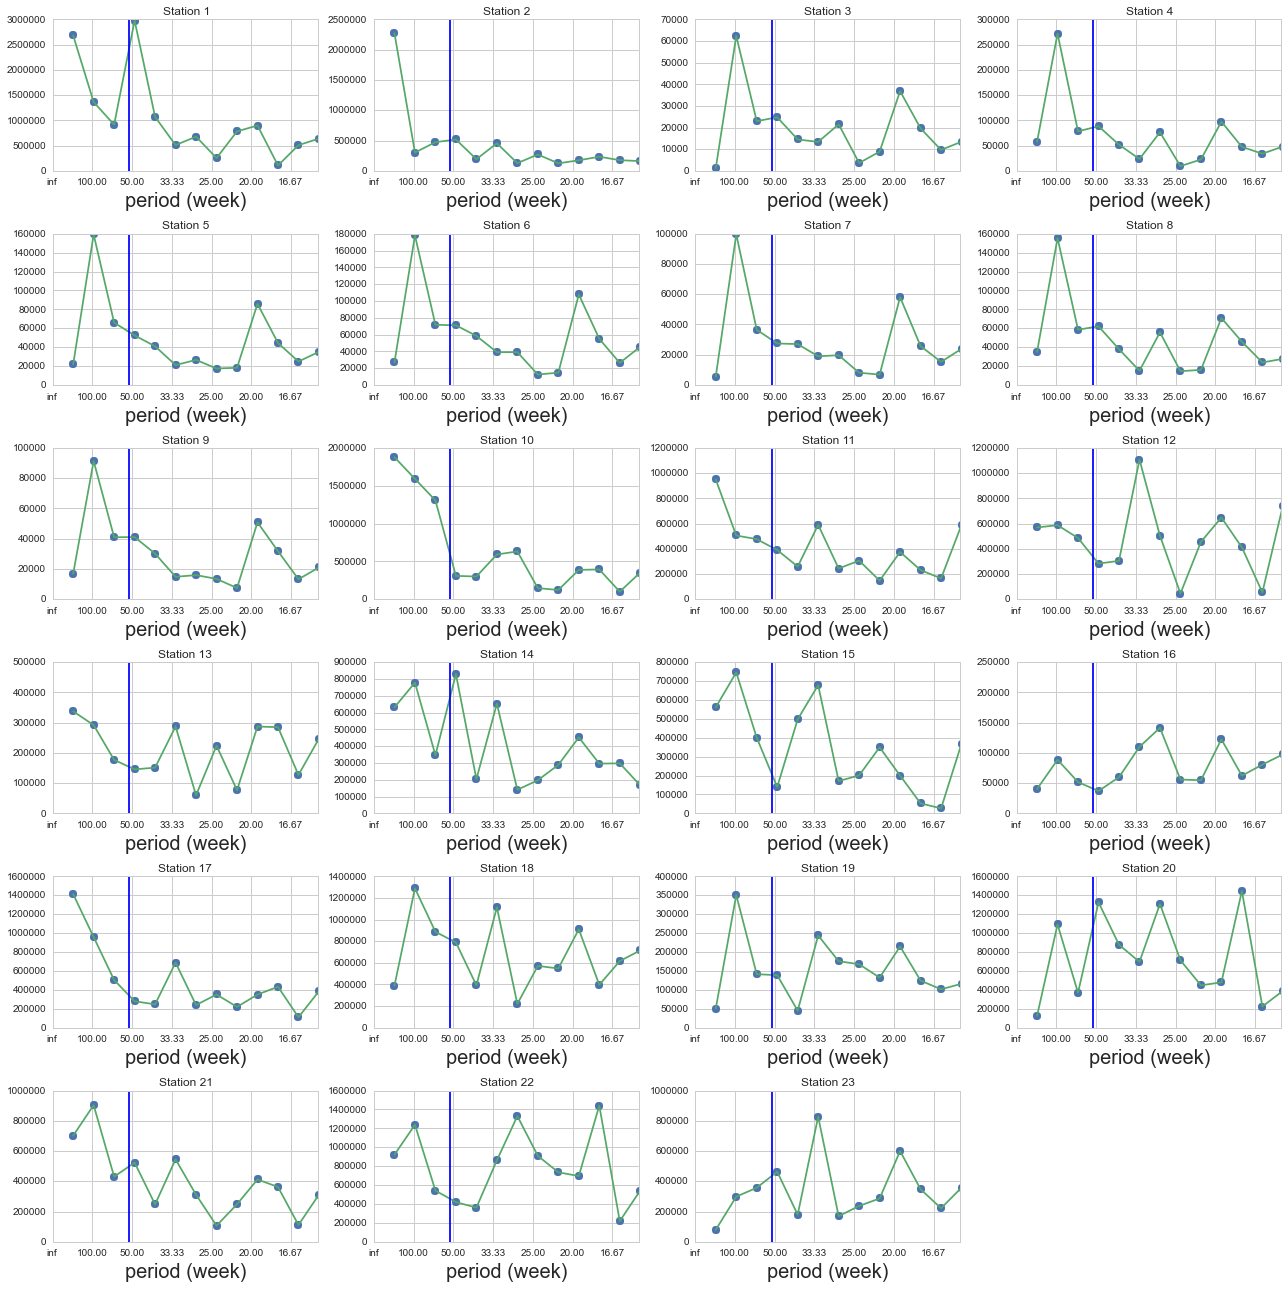

In [26]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,18))
annual = np.zeros(600)
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            f = np.abs(np.fft.rfft(mta_allsum.loc[i*4+j,:]))
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=8)
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
            ax.set_xlim(0,1.0/15)
            ax.set_xticklabels([ "%.2f"%(1/f) for f in ax.get_xticks()], fontsize=10)
            pl.xlabel("period (week)", fontsize=20)
            plt.axvline(1.0/52)
            ax.set_title("Station %d"%(i*4+j+1))
fig.tight_layout()

In [28]:
annual = np.zeros(600)
for i in range(600):
    annual[i] = np.abs(np.fft.rfft(mta_allsum.loc[i,:])[4])

In [30]:
from operator import itemgetter
indices, L_sorted = zip(*sorted(enumerate(annual), key=itemgetter(1)))

In [33]:
print (indices[599], indices[598], indices[597], indices[596])

(0, 194, 150, 327)


The stations with the most prominent annual periodicity are 0, 194, 150, 327.